In [12]:
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("..")

import anamic

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
import skimage

/home/hadim/local/conda/envs/ws/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


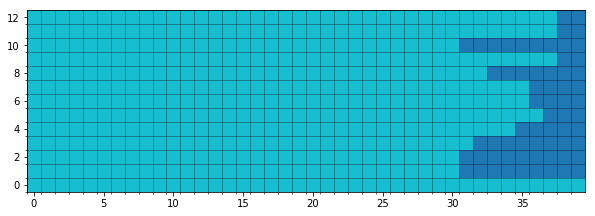

In [45]:
n_pf = 13
n_rows = 40

dimers = np.ones((n_pf, n_rows))
dimers = anamic.structure.generate_random_tapers(dimers, 0, 10)

_ = anamic.viz.viz_dimers(dimers, start_row=0, grid=True)

In [52]:
positions = anamic.structure.get_dimer_positions(dimers)
anamic.viz.viz_dimer_positions(positions, size=3, color_feature_name='pf')

In [53]:
# Apply a random rotation parallell to the surface (along the z axis)
rotation = np.deg2rad(np.random.randn() * 360)
Rz = anamic.transformations.rotation_matrix(rotation, [0, 0, 1])
positions[['x', 'y', 'z']] = np.dot(positions[['x', 'y', 'z']].values, Rz[:3, :3].T)

In [87]:
# Apply a certain labeling ratio
labeling_ratio = 0.1
positions['labeled'] = np.random.random(positions.shape[0]) < labeling_ratio

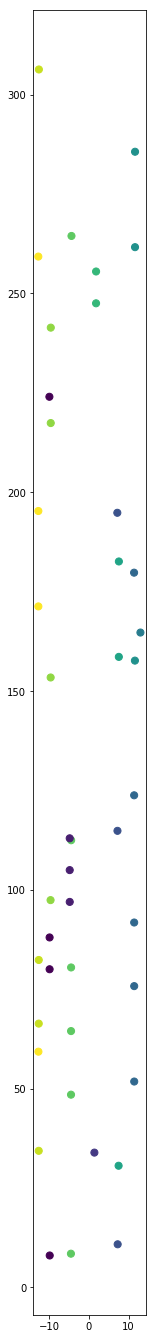

In [88]:
# We choose the XZ plan for projection so no need to project positions.
# The x, y coordinate correspond to the projected one.

selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]

fig, ax = plt.subplots(figsize=(16, 24))
ax.scatter(selected_dimers['x'], selected_dimers['z'], c=selected_dimers['pf'], s=50, cmap='viridis')
ax.set_aspect('equal')
#ax.set_ylim(600, 620)

In [89]:
# Discretize dimers onto an high resolution image

pixel_size = 0.5  # nm/pixel
x_offset = 50  # nm
y_offset = 50  # nm

x_max = int(np.round(positions['x'].max() + 1))
x_min = int(np.round(positions['x'].min() - 1))
y_max = int(np.round(positions['z'].max() + 1))
y_min = int(np.round(positions['z'].min() - 1))

x_bins = np.arange(x_min - x_offset, x_max + x_offset, pixel_size)
y_bins = np.arange(y_min - y_offset, y_max + y_offset, pixel_size)

selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]

im, _, _ = np.histogram2d(selected_dimers['x'], selected_dimers['z'], bins=[x_bins, y_bins])
im = im.T[::-1]

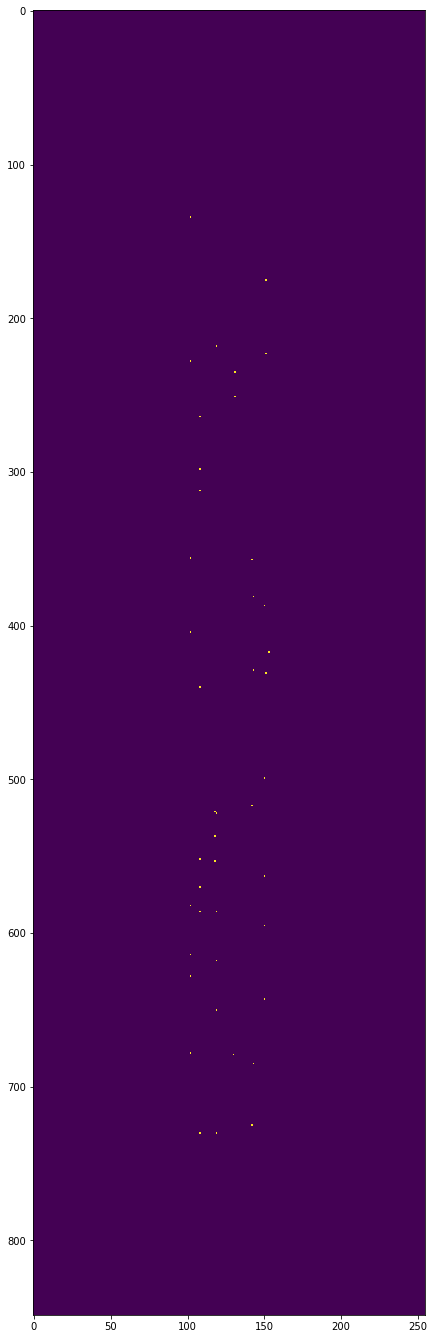

In [90]:
fig, ax = plt.subplots(figsize=(16, 24))
ax.imshow(im, interpolation='none')
ax.set_aspect('equal')
#ax.set_ylim(600, 620)

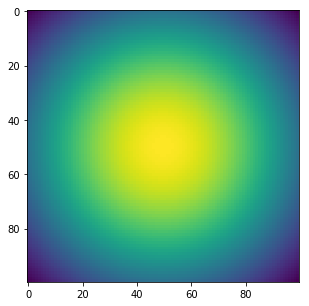

In [91]:
def generate_psf(kernel_size_pixel, sigma_pixel):
    from scipy import signal
    gaussian_kernel_1d = signal.gaussian(kernel_size_pixel, std=sigma_pixel)
    gaussian_kernel_1d = gaussian_kernel_1d.reshape(kernel_size_pixel, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    return gaussian_kernel_2d

psf = generate_psf(100, 50)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(psf, interpolation='none')
ax.set_aspect('equal')

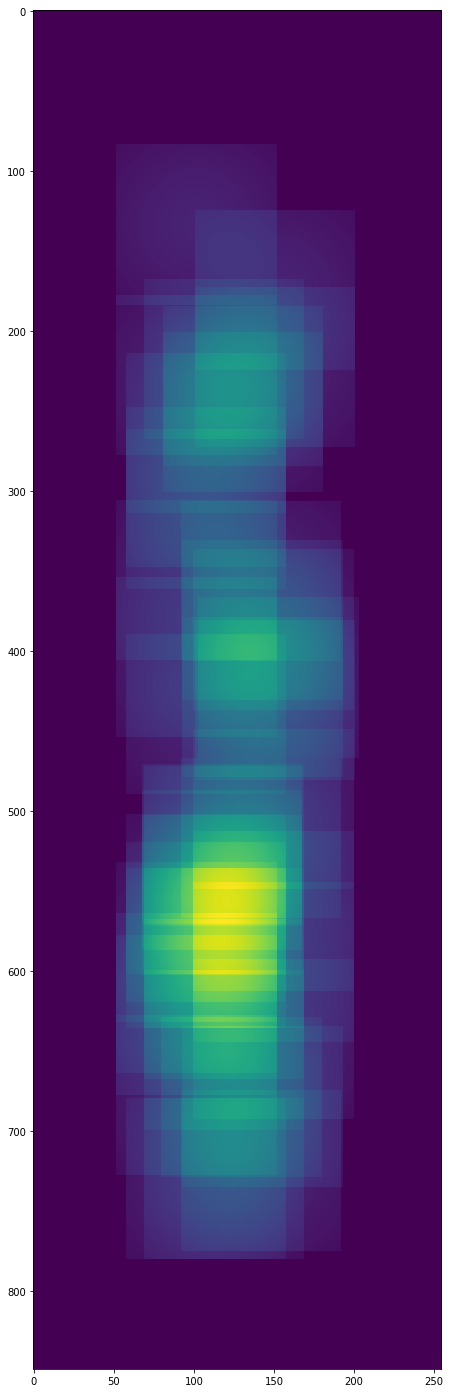

In [92]:
from scipy.ndimage import convolve

a = convolve(im, psf, )

fig, ax = plt.subplots(figsize=(25, 25))
ax.imshow(a, interpolation='none')
ax.set_aspect('equal')